# Hamming Weight Preserving Quantum Convolutional Neural Network

In this notebook, I will detail the implementation of a hamming weight preserving quantum convolutional neural network and perform some rudimentary benchmarking.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from torchquantum import QuantumDevice
from src import OneHotAmplitude, QConv2d, QPooling, OneHotAmplitude, PyramidQDense, MeasureLayer 
import matplotlib.pylab as plt

In [ ]:
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15 
plt.rcParams['ytick.labelsize'] = 15 
plt.rcParams['axes.labelsize'] = 20 
plt.rcParams['axes.titlesize'] = 19 
plt.rc('font', **{'family': 'serif', 'serif':['Computer Modern']})
plt.rc('text', usetex=True)

Quantum convolutional neural networks (QCNNs) were first proposed in Ref [1] as the quantum analogue to the classical convolutional neural network (CNN). CNNs have been widely implemented in a broad range of machine learning applications, including image recognition, natural language processing and speech recognition. The general structure of QCNNs aim to mimic that of the classical convolutional neural network and generally consist of variational "convolutional" and "dense" layers as well as measurement based pooling layers.

<p align="center">
    <img src="figures/QCNN_diagram.png" alt="QCNN architecture" width="700">
</p>

Recently hamming weight preserving circuits have gained interest as efficiently trainable quantum models which escape the problem of "barren plateaus". These are regions where the gradient of the loss landscape vanishes exponentially with the system size and are a common obstacle faced by quantum machine learning models. In this notebook, we reproduce the hamming weight preserving QCNN presented in Ref. [2] and train it on a subset of the MNIST dataset with reduced dimensions.

First let us define the dimensions and batch size of our data-loader and import our dataset.

In [ ]:
# Define dimensions and batch size
dims = (8, 8)
batch_size = 16

# Define transforms
transform = transforms.Compose([
    transforms.Resize(dims),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST
])

# Load training and test datasets
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
val_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Consider 1/10th of the datasets.
train_indices = torch.randperm(60_000)[:6000]
val_indices = torch.randperm(10_000)[:1000]

train_dataset = Subset(train_dataset, train_indices.tolist())
val_dataset = Subset(val_dataset, val_indices.tolist())

# Dataloader for training QCNN
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=True
)


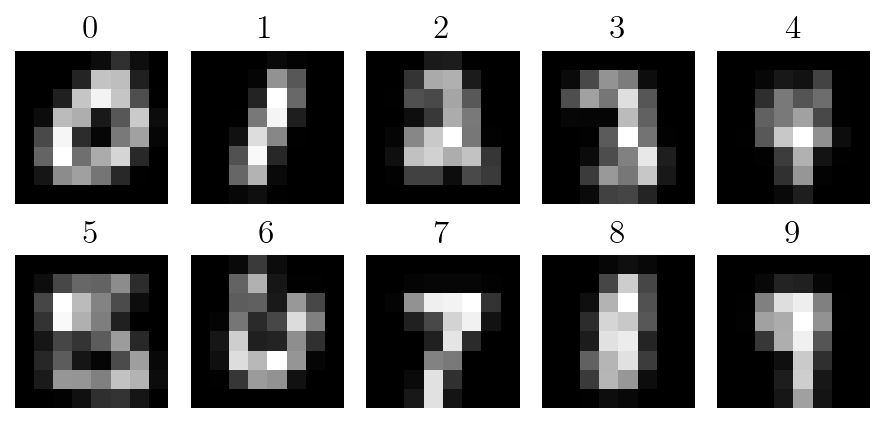

In [51]:
# Visualize an example of each possible digit in the MNIST dataset under our transformation.
mnist_examples = {}
for image, label in train_dataset:
    if label not in mnist_examples:
        mnist_examples[label] = image.squeeze()
    if len(mnist_examples) == 10:
        break

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(6, 3), dpi=150)
for idx, (digit, image) in enumerate(sorted(mnist_examples.items())):
    row, col = divmod(idx, 5)
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'{digit}', fontsize=16)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('figures\MNIST_8x8.png', dpi=400)
plt.show()

## The Model 

### **Encoding**

Each pixel is encoded using a form of amplitude encoding and is represented by a distinct basis state. Two registers are set up representing the $x$ and $y$ dimensions with a hamming weight of 1 in each register. For a $H \times W$ image, $\mathbf{X}$, the image statevector is given by:

$$|\mathbf{X} \rangle = \frac{1}{\lVert \mathbf{X} \rVert_2} \sum_{i}^{H} \sum_{j}^{W} x_{i, j}  |e^{H}_{i} \rangle |e^{W}_{j} \rangle$$

where each basis state is given by: $|e^{d}_{i} \rangle = |0 \rangle^{ \otimes d} |1 \rangle |0 \rangle ^{\otimes (d - i - 1)}$.


### **Convolutional Layer**

The convolutional layer consists of a series of convolutional filters applied to the two registers separately. Similar to that of a classical convolution this corresponds to linear operations applied to each submatrix within the image via a "filter" of size $k \times k$ where $k$ is the kernel size. A schematic derived from Ref. [3] is displayed below. 

<p align="center">
    <img src="figures/Convolutional_layer.png" alt="Pooling layer" width="1000">
</p>

Within a classical convolution, the stride represents the distance the filter moves across the image. However, in this context a filter with a kernel size less than the stride would break the translational invariance of the quantum convolutional layer. 

We consider convolutional filters made up of gates referred to by Ref. [3] as the "Reconfigurable Beam-splitter" (RBS) gate. Its unitary form is given by:

$$ 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & \cos(\theta) & \sin(\theta) & 0 \\
0 & -\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$




### **Pooling**

Within the pooling layer, the dimension of the image is reduced by the specified kernel size. In this model, a CNOT is applied consectively and the control qubits are discarded in order to reduce the dimension of the image in a hamming-weight preserving manner:

<p align="center">
    <img src="figures/Pooling_layer.png" alt="Pooling layer" width="300">
</p>


### **Dense**

In the dense layer, we merge the $x$ and $y$ registers and perform a global operation consisting of the RBS gates. Ref. [3] gives a number of possible dense layers including "Pyramidal Dense" shown below. 

<p align="center">
    <img src="figures/Pyramidal_Dense_layer.png" alt="Pyramidal Dense layer" width="900">
</p>

Here each green cell represents an RBS gate. Immediately following the dense layer the remaining qubits are measured. The output tensor of the dense layer then is taken to be the set of probabilities corresponding to each output state. in this notebook, to map the state onto the output dimensions corresponding to that of the MNIST dataset, we use a classical linear layer.



In [6]:
class QCNN(torch.nn.Module):
    """ 
    Quantum Convolutional Neural Network 

    QCNN consisting of quantum encoding, convolutional, pooling layers and 
    a classical linear layer to project the data onto the output dimension.

    :param dims: Input image dimensions.
    :param temperature: Softmax temperature used to evaluate the cross entropy loss.
    """

    def __init__(self, dims, temperature: float = 1.0):
        super().__init__()
        self.dims = dims
        self.temperature = temperature

        self._encoder = OneHotAmplitude(dims)
        self._qconv1 = QConv2d(dims, kernel_size=2)
        self._qpool1 = QPooling(dims, kernel_size=2)
        self._qdense = PyramidQDense(n_wires=sum(dims) // 2)
        self._measure = MeasureLayer(n_wires=sum(dims) // 2)

        # Convert to MNIST dimension.
        self.num_measurements = len(list(self._measure.output_states()))
        self._postprocess = torch.nn.Linear(self.num_measurements, 10, bias=True)

    def forward(self, X):
        if X.shape[-2:] != self.dims:
            raise ValueError('Image dimensions do not match QCNN dimensions.')

        # Remove channels dimension
        if len(X.shape) == 4:
            X = X.squeeze(1)

        # Pass through network
        qdev = QuantumDevice(n_wires=sum(X.shape[1:]))
        self._encoder(qdev, X) 
        self._qconv1(qdev) 
        self._qpool1(qdev)    
        self._qdense(qdev)
        
        # Measure & perform post-processing
        probs = self._measure(qdev)
        output = probs / self.temperature
        output = self._postprocess(output)
        return output

temperature = 0.015
qcnn = QCNN(dims, temperature)

num_params = sum(p.numel() for p in qcnn.parameters() if p.requires_grad)
print(f'QCNN has {num_params} parameters, \n')

QCNN has 323 parameters, 



Set up the following directory for logging. The logging of this project uses the following notation

QCNN Structure:
- ```C(k=2, s=2)```: Convolution kernel size $= 2$, stride $= 2$. <br>
- ```P(k=2)```: Pooling kernel size $= 2$, stride $= 2$ <br>
- ```PD```: Pyramidal dense layer. <br>
- ```L```: Classical linear layer 

Hyperparameters:
- ```T=0.015```: 0.015 Softmax temperature. <br>
- ```batch_size=16```: 16 batch size for training and evaluation. <br>
- ```lr=0.001```: Learning rate $= 0.001$. <br>

In [ ]:
lr = 1e-3 # Learning rate 
model_description = f'C(k=2, s=2)-P(k=2)-PD-L'
log_dir = f'logs/{dims[0]}x{dims[1]} {model_description} T={temperature} batch_size={batch_size} lr={lr}' 

Run the following cell if you'd like to set up a checkpoint

In [ ]:
# with np.load(log_dir + '/history.npz') as data:
#     train_losses_qcnn = list(data['train_losses'])
#     train_accuracies_qcnn = list(data['train_accuracies'])
#     val_accuracies_qcnn = list(data['val_accuracies'])

# qcnn.load_state_dict(torch.load(log_dir + '/qcnn_weights.pth', weights_only=False))

# Reset how many more epochs you want to run 
#num_epochs = 10

<All keys matched successfully>

Now perform training on the reduced dataset.

In [ ]:
num_epochs = 50

# Device configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qcnn.parameters(), lr=lr)

if 'train_accuracies_qcnn' not in locals(): # Check if loading from a checkpoint
    train_losses_qcnn = []
    train_accuracies_qcnn = []
    val_accuracies_qcnn = [] 

    qcnn.eval()
    with torch.no_grad():
        running_correct = 0
        total_samples = 0
        val_running_correct = 0
        val_total_samples = 0

        # Evaluate first total accuracy over the entire training and validation sets
        for train_images, train_labels in train_loader: 
            train_images, train_labels = train_images.to(device), train_labels.to(device)
            train_outputs = qcnn(train_images)

            _, train_preds = torch.max(train_outputs, 1)
            running_correct += (train_preds == train_labels).sum().item()
            total_samples += train_labels.size(0)

        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = qcnn(val_images)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_correct += (val_preds == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    train_accuracy = running_correct / total_samples
    val_accuracy = val_running_correct / val_total_samples

    train_accuracies_qcnn = [train_accuracy]
    val_accuracies_qcnn = [val_accuracy]
        

for epoch in range(num_epochs):
    # Training phase
    qcnn.train()
    running_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = qcnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_qcnn.append(loss.item())

        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    train_accuracy = running_correct / total_samples
    train_accuracies_qcnn.append(train_accuracy)

    # Validation phase
    qcnn.eval()
    val_running_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = qcnn(val_images)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_correct += (val_preds == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    val_accuracy = val_running_correct / val_total_samples
    val_accuracies_qcnn.append(val_accuracy)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}] "
        f"Train Acc: {train_accuracy:.4f} "
        f"Val Acc: {val_accuracy:.4f} "
        f"Loss: {loss.item():.4f}"
    )

Save the results. 

In [11]:
train_losses_qcnn = np.array(train_losses_qcnn)
train_accuracies_qcnn = np.array(train_accuracies_qcnn)
val_accuracies_qcnn = np.array(val_accuracies_qcnn)

# Save to logs 
torch.save(qcnn.state_dict(), log_dir + '/qcnn_weights.pth')

np.savez_compressed(
    log_dir + '/history.npz',
    train_losses=train_losses_qcnn,
    train_accuracies=train_accuracies_qcnn,
    val_accuracies=val_accuracies_qcnn,
)


--------------------------
# Rough Classical Benchmarking

The choice of a classical benchmark is a difficult one as the quantum equivalents do not directly map onto their classical counterparts one to one. For instance, the convolution described in Ref. [3] preserves the dimension of the image. Arguably `QConv2d` + `QPooling` is a better quantum analogue of a single classical convolution. 

In the following cells, I only make an approximate benchmark and do not argue an advantage for either model. A better analysis would require a quantum model pitted against a more complete CNN including features such as pooling layers, channels, padding and so on.

In [48]:
class CNN(torch.nn.Module):
    """ 
    Convolutional Neural Network 

    Approximate classical equivalent of QCNN in this notebook.
    """

    def __init__(self, dims):
        super().__init__()
        self.dims = dims
        self.temperature = temperature

        self._conv = torch.nn.Conv2d(kernel_size=2, stride=2, in_channels=1,out_channels=1)
        self._flatten = torch.nn.Flatten() 
        self._relu = torch.nn.ReLU()

        # In the dense layer, choose hidden layer dimensions so that the number of parameters 
        # approximately matches that of the QCNN.
        self._linear1 =  torch.nn.Linear(in_features=16, out_features=12, bias=False) 
        self._linear2 =  torch.nn.Linear(in_features=12, out_features=10, bias=True)


    def forward(self, X):
        if X.shape[-2:] != self.dims:
            raise ValueError('Image dimensions do not match CNN dimensions.')

        X = self._conv(X)
        X = self._relu(X)
        X = self._flatten(X)
        X = self._linear1(X)
        X = self._relu(X)
        X = self._linear2(X)

        return X

cnn = CNN(dims)
num_params = sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(f'CNN has {num_params} parameters')

CNN has 327 parameters


In [ ]:
# Device configuration 
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)

train_losses_cnn = []

# Perform evaluation before training
cnn.eval()
with torch.no_grad():
    running_correct = 0
    total_samples = 0
    val_running_correct = 0
    val_total_samples = 0

    for train_images, train_labels in train_loader: 
        train_images, train_labels = train_images.to(device), train_labels.to(device)
        train_outputs = cnn(train_images)

        _, train_preds = torch.max(train_outputs, 1)
        running_correct += (train_preds == train_labels).sum().item()
        total_samples += train_labels.size(0)

    for val_images, val_labels in val_loader:
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        val_outputs = cnn(val_images)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_correct += (val_preds == val_labels).sum().item()
        val_total_samples += val_labels.size(0)

train_accuracy = running_correct / total_samples
val_accuracy = val_running_correct / val_total_samples

train_accuracies_cnn = [train_accuracy]
val_accuracies_cnn = [val_accuracy]
        

for epoch in range(num_epochs):

    # Training phase
    cnn.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses_cnn.append(loss.item())


        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_accuracy = running_correct / total_samples
    train_accuracies_cnn.append(epoch_accuracy)

    # Validation phase
    cnn.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = cnn(val_images)

            _, val_preds = torch.max(val_outputs, 1)
            val_running_correct += (val_preds == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    val_epoch_accuracy = val_running_correct / val_total_samples
    val_accuracies_cnn.append(val_epoch_accuracy)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}] "
        f"Loss: {loss.item():.4f} "
        f"Train Acc: {epoch_accuracy:.4f} "
        f"Val Acc: {val_epoch_accuracy:.4f}"
    )

Plot the loss, training and validation curves over the course of the training. Note that the training accuracy at each epoch is the average cumulative accuracy over the course of that epoch while the validation accuracy represents the accuracy of the total dataset at the end of each epoch.

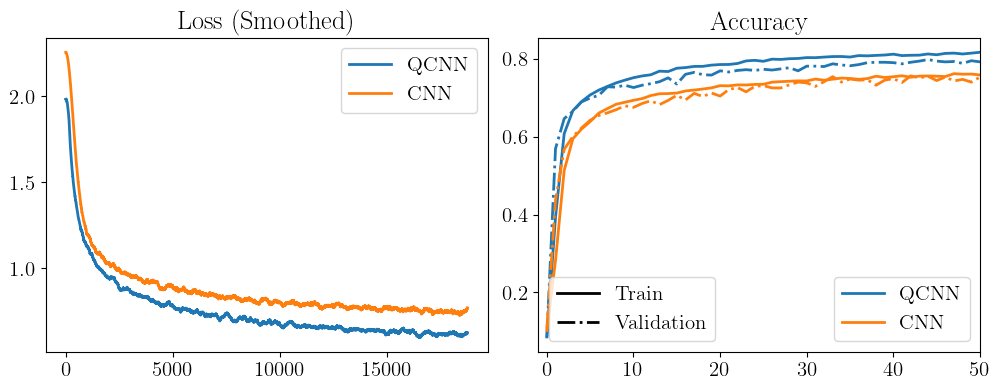

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

plt.figure(figsize=(10, 4))

# First subplot: Loss
plt.subplot(1, 2, 1)
plt.plot(uniform_filter(train_losses_qcnn, size=len(train_loader)), linewidth=2, label='QCNN')
plt.plot(uniform_filter(train_losses_cnn, size=len(train_loader)), linewidth=2, label='CNN')
plt.legend()
plt.title('Loss (Smoothed)')

# Second subplot: Accuracy
ax2 = plt.subplot(1, 2, 2)
plt.title('Accuracy')
l1, = ax2.plot(train_accuracies_qcnn, label='QCNN', linewidth=2)
l2, = ax2.plot(val_accuracies_qcnn, c='tab:blue', linewidth=2, linestyle='-.')
l3, = ax2.plot(train_accuracies_cnn, label='CNN', linewidth=2)
l4, = ax2.plot(val_accuracies_cnn, c='tab:orange', linewidth=2, linestyle='-.')
plt.xlim(-1, num_epochs)

# First legend: model type
legend1 = ax2.legend(handles=[l1, l3], loc='lower right')
ax2.add_artist(legend1)

# Second legend: line style (train/val)
train_line, = ax2.plot([], c='black', linewidth=2, label='Train')
val_line, = ax2.plot([], c='black', linewidth=2, linestyle='-.', label='Validation')
ax2.legend(handles=[train_line, val_line], loc='lower left')

plt.tight_layout()
plt.show()

In [56]:
print(f'QCNN:')
print(f'Final training accuracy {train_accuracies_qcnn[-1]}')
print(f'Final validation accuracy {val_accuracies_qcnn[-1]}, \n')
print(f'CNN:')
print(f'Final training accuracy {train_accuracies_cnn[-1]}')
print(f'Final validation accuracy {val_accuracies_cnn[-1]}')

QCNN:
Final training accuracy 0.8176666666666667
Final validation accuracy 0.793, 

CNN:
Final training accuracy 0.7593333333333333
Final validation accuracy 0.754


-------------------------

## References 

[1] I. Cong, S. Choi, and M. D. Lukin, "Quantum convolutional neural networks," Nature Physics, vol. 15, no. 12, pp. 1273–1278, Aug. 2019, doi: 10.1038/s41567-019-0648-8.
 
[2] L. Monbroussou, E. Z. Mamon, J. Landman, A. B. Grilo, R. Kukla, and E. Kashefi, “Trainability and expressivity of Hamming-weight preserving quantum circuits for machine learning,” Quantum, vol. 9, p. 1745, May 2025. doi: 10.22331/q-2025-05-15-1745.

[3] L. Monbroussou, J. Landman, L. Wang, A. B. Grilo, and E. Kashefi, “Subspace preserving quantum convolutional neural network architectures,” Quantum Science and Technology, vol. 10, no. 2, p. 025050, Mar. 2025. doi: 10.1088/2058-9565/adbf43.
